In [1550]:
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix
from pandas import DataFrame
import pickle, random
from tqdm import tqdm
from scipy.spatial import KDTree

In [1551]:
from collections import Counter
from imblearn.under_sampling import RandomUnderSampler

In [1552]:
#df0 = pd.read_csv('../spreadsheets/rlhf_1064.csv')
#df0 = pd.read_csv('../spreadsheets/rlhf_159nlp2.csv') # second Best
df0 = pd.read_csv('../spreadsheets/rlhf_small_07rl.csv') # Best
#df0 = pd.read_csv('../spreadsheets/rlhf_small_08rl.csv')

In [1553]:
#df0['action'] = df0['action'].replace('go_long', 'do_nothing')

In [1554]:
df0.head()

,Unnamed: 0,sma-05 (entry),sma-07 (entry),sma-25 (entry),sma-compare (entry),is_short,action,imit-action,nlpreds,reward
0,0,5586.80000,5581.714286,5538.800000,0,0,go_long,go_short,go_long,-7.544025
1,1,174.80200,174.648571,172.701200,0,0,go_long,go_short,go_long,-9.342693
2,2,1.07052,1.059957,1.047988,0,0,go_long,go_short,go_long,-15.127052
3,3,2152.66000,2150.228571,2121.036000,0,0,go_long,go_short,go_long,-19.396349
4,4,1.18500,1.181571,1.169520,0,0,go_long,go_short,go_long,-16.576807


In [1555]:
df0['nlpreds'].value_counts()

nlpreds
go_long     2810
go_short     540
Name: count, dtype: int64

In [1556]:
def prep_data(df: DataFrame) -> DataFrame:
    train_data = pd.DataFrame()
    for col in df.columns:
        col_name = col.split(' ')[0]
        train_data[f'{col_name}'] = df[col]

    return train_data

In [1557]:
train_data = prep_data(df0)

In [1558]:
train_data.head(2)

,Unnamed:,sma-05,sma-07,sma-25,sma-compare,is_short,action,imit-action,nlpreds,reward
0,0,5586.800,5581.714286,5538.8000,0,0,go_long,go_short,go_long,-7.544025
1,1,174.802,174.648571,172.7012,0,0,go_long,go_short,go_long,-9.342693


In [1559]:
# Encode actions into numerical values
action_mapping = {"go_long": 0, "go_short": 1, "do_nothing": 2}
train_data["action_num"] = train_data["action"].map(action_mapping)

In [1560]:
# Define RL parameters
states = train_data[["sma-05", "sma-07", "sma-25", "sma-compare", "is_short"]].values  # Include binary_state
actions = list(action_mapping.values())  # Action space
rewards = train_data["reward"].values  # Rewards
n_states = states.shape[0]
n_actions = len(actions)

In [1561]:
# Initialize Q-table
q_table = np.zeros((n_states, n_actions))

In [1562]:
# Hyperparameters [0.25, 0.95, 1.0, 0.99, 0.99, 10000], [0.3, 0.75, 1.0, 0.995, 0.99, 10000], [0.7, 0.99, 1.0, 0.95, 0.997, 8000]
# [1, 0.9, 1.0, 0.999, 0.999, 10000], [1, 0.95, 0.1, 0.96, 0.96, 12000], [0.7, 0.75, 1.0, 0.97, 0.999, 28000]
alpha = 0.7
gamma = 0.75
epsilon = 1.0
min_epsilon = 0.97
decay_rate = 0.97
n_episodes = 28000
n_states = states.shape[0]  # Number of states
n_actions = len(actions)  # Number of actions



In [1563]:
def create_state_index_mapping(df):
    state_to_index = {}
    for idx, row in df.iterrows():
        state = (row['sma-05'], row['sma-07'], row['sma-25'], row['sma-compare'], row['is_short'])
        state_to_index[state] = idx
    return state_to_index

# Assuming 'df' is your dataframe used during training
state_to_index = create_state_index_mapping(train_data)

# Save the state_to_index dictionary for later use
np.save('small_state_to_index.npy', state_to_index)


In [1564]:

# Helper function to choose an action using epsilon-greedy
def choose_action(state, epsilon):
    if np.random.uniform(0, 1) < epsilon:
        return np.random.randint(0, n_actions)  # Explore: random action
    else:
        return np.argmax(q_table[state])  # Exploit: best known action


evaluating results per episode ...:   0%|          | 19/28000 [00:00<05:18, 87.96it/s]

Episode 0/28000 - Total Reward: -3988.8627076700013, Epsilon: 0.97


evaluating results per episode ...:   4%|▎         | 1017/28000 [00:11<05:11, 86.62it/s]

Episode 1000/28000 - Total Reward: -3078.5051101400013, Epsilon: 0.97


evaluating results per episode ...:   7%|▋         | 2027/28000 [00:21<04:19, 100.10it/s]

Episode 2000/28000 - Total Reward: 1308.6121331199813, Epsilon: 0.97


evaluating results per episode ...:  11%|█         | 3024/28000 [00:31<03:47, 109.73it/s]

Episode 3000/28000 - Total Reward: -2289.042964309999, Epsilon: 0.97


evaluating results per episode ...:  14%|█▍        | 4012/28000 [00:41<04:07, 97.05it/s] 

Episode 4000/28000 - Total Reward: 2213.484321359979, Epsilon: 0.97


evaluating results per episode ...:  18%|█▊        | 5011/28000 [00:52<03:46, 101.66it/s]

Episode 5000/28000 - Total Reward: 516.9345535099976, Epsilon: 0.97


evaluating results per episode ...:  21%|██▏       | 6008/28000 [01:02<03:40, 99.64it/s] 

Episode 6000/28000 - Total Reward: -3058.951462760001, Epsilon: 0.97


evaluating results per episode ...:  25%|██▌       | 7021/28000 [01:12<03:32, 98.91it/s] 

Episode 7000/28000 - Total Reward: -1879.1254206499984, Epsilon: 0.97


evaluating results per episode ...:  29%|██▊       | 8008/28000 [01:22<03:08, 106.23it/s]

Episode 8000/28000 - Total Reward: -3566.269493100003, Epsilon: 0.97


evaluating results per episode ...:  32%|███▏      | 9015/28000 [01:32<03:42, 85.37it/s] 

Episode 9000/28000 - Total Reward: 2173.661645339979, Epsilon: 0.97


evaluating results per episode ...:  36%|███▌      | 10017/28000 [01:42<02:55, 102.36it/s]

Episode 10000/28000 - Total Reward: -3730.1808814200012, Epsilon: 0.97


evaluating results per episode ...:  39%|███▉      | 11013/28000 [01:53<03:20, 84.58it/s] 

Episode 11000/28000 - Total Reward: -2500.34821228, Epsilon: 0.97


evaluating results per episode ...:  43%|████▎     | 12013/28000 [02:03<03:02, 87.43it/s] 

Episode 12000/28000 - Total Reward: -1874.8389551799987, Epsilon: 0.97


evaluating results per episode ...:  46%|████▋     | 13015/28000 [02:13<02:27, 101.30it/s]

Episode 13000/28000 - Total Reward: -3432.438499040003, Epsilon: 0.97


evaluating results per episode ...:  50%|█████     | 14015/28000 [02:23<02:21, 98.63it/s] 

Episode 14000/28000 - Total Reward: -2308.41956453, Epsilon: 0.97


evaluating results per episode ...:  54%|█████▎    | 15017/28000 [02:34<02:25, 89.12it/s] 

Episode 15000/28000 - Total Reward: -3795.4634781000013, Epsilon: 0.97


evaluating results per episode ...:  57%|█████▋    | 16015/28000 [02:44<01:57, 101.70it/s]

Episode 16000/28000 - Total Reward: 240.8478857999988, Epsilon: 0.97


evaluating results per episode ...:  61%|██████    | 17013/28000 [02:55<02:09, 84.65it/s] 

Episode 17000/28000 - Total Reward: 560.9872708999943, Epsilon: 0.97


evaluating results per episode ...:  64%|██████▍   | 18020/28000 [03:05<01:43, 96.17it/s] 

Episode 18000/28000 - Total Reward: -4658.927709300001, Epsilon: 0.97


evaluating results per episode ...:  68%|██████▊   | 19021/28000 [03:16<01:39, 90.62it/s] 

Episode 19000/28000 - Total Reward: -2175.544563459999, Epsilon: 0.97


evaluating results per episode ...:  71%|███████▏  | 20018/28000 [03:26<01:20, 99.05it/s] 

Episode 20000/28000 - Total Reward: 226.41985180999822, Epsilon: 0.97


evaluating results per episode ...:  75%|███████▌  | 21015/28000 [03:37<01:07, 103.16it/s]

Episode 21000/28000 - Total Reward: -477.3145359199999, Epsilon: 0.97


evaluating results per episode ...:  79%|███████▊  | 22008/28000 [03:47<01:07, 89.10it/s] 

Episode 22000/28000 - Total Reward: -3510.8516622000025, Epsilon: 0.97


evaluating results per episode ...:  82%|████████▏ | 23009/28000 [03:58<00:47, 105.70it/s]

Episode 23000/28000 - Total Reward: -2694.05425832, Epsilon: 0.97


evaluating results per episode ...:  86%|████████▌ | 24019/28000 [04:08<00:40, 99.24it/s] 

Episode 24000/28000 - Total Reward: 1760.2140383899791, Epsilon: 0.97


evaluating results per episode ...:  89%|████████▉ | 25019/28000 [04:18<00:28, 104.70it/s]

Episode 25000/28000 - Total Reward: -2873.656837209999, Epsilon: 0.97


evaluating results per episode ...:  93%|█████████▎| 26010/28000 [04:28<00:20, 99.09it/s] 

Episode 26000/28000 - Total Reward: 1679.8097242799784, Epsilon: 0.97


evaluating results per episode ...:  97%|█████████▋| 27022/28000 [04:39<00:09, 107.84it/s]

Episode 27000/28000 - Total Reward: -5096.41384505, Epsilon: 0.97


evaluating results per episode ...: 100%|██████████| 28000/28000 [04:49<00:00, 96.75it/s] 


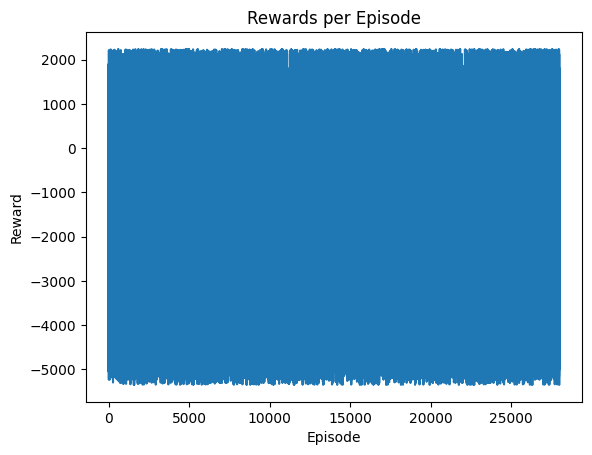

In [1565]:

# Set random seed for reproducibility and train the loop
np.random.seed(42)
random.seed(42)
# Initialize a list to store rewards per episode
rewards_per_episode = []

for episode in tqdm(range(n_episodes), desc="evaluating results per episode ..."):
    current_state = np.random.randint(0, n_states)  # Random initial state
    total_reward = 0  # Initialize total reward for the current episode

    while current_state < n_states - 1:
        action = choose_action(current_state, epsilon)
        
        next_state = current_state + 1  # This depends on your environment logic
        reward = rewards[next_state]

        best_next_action = np.argmax(q_table[next_state])
        q_table[current_state, action] += alpha * (
            reward + gamma * q_table[next_state, best_next_action] - q_table[current_state, action]
        )
        
        total_reward += reward  # Accumulate reward for the current episode
        current_state = next_state  # Move to next state

    rewards_per_episode.append(total_reward)  # Store the total reward for the current episode

    # Decay epsilon
    epsilon = max(min_epsilon, epsilon * decay_rate)

    # Optional: Log progress
    if episode % 1000 == 0:  # Adjust logging frequency as needed
        print(f"Episode {episode}/{n_episodes} - Total Reward: {total_reward}, Epsilon: {epsilon}")

# Example: Save the Q-table
np.save("small_q_table.npy", q_table)

# Example: Plotting the rewards
import matplotlib.pyplot as plt

plt.plot(rewards_per_episode)
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('Rewards per Episode')
plt.show()


In [1566]:
def load_q_table(file_path):
    return np.load(file_path)

def load_state_index_mapping(file_path):
    return np.load(file_path, allow_pickle=True).item()

loaded_mapping = load_state_index_mapping(file_path="small_state_to_index.npy")
loaded_qtable = load_q_table(file_path="small_q_table.npy")

In [1567]:
def prep_state(sma_05: float, sma_07: float, sma_25: float, sma_compare: int, is_short: int):
    state = np.array([[sma_05, sma_07, sma_25, sma_compare, is_short]])
    if not np.all(np.isfinite(state)):
        state = np.nan_to_num(state, nan=0.0, posinf=0.0, neginf=0.0)
    return state



In [1568]:

def predict_action(state, q_table, state_to_index, action_mapping, default_action: str = None):
    state_tuple = tuple(state.flatten())

    state_index = state_to_index.get(state_tuple, -1)

    if not state_index == -1:
        try:
            q_values = q_table[state_index]
        except ValueError as e:
            print(e)
            #return default_action
    else:
        state_tuples = list(state_to_index.keys())
        kdtree = KDTree(state_tuples)
        distance, index = kdtree.query(state.flatten())
        nearest_state_tuple = state_tuples[index]
        new_state_index = state_to_index[nearest_state_tuple]
        q_values = loaded_qtable[new_state_index]
    
    #q_values = q_table[state_index]
    best_action_index = np.argmax(q_values)
    action = [action for action, index in action_mapping.items() if index == best_action_index][0]
    return action


In [1569]:
# Example usage:
with open("small_q_table.npy", "rb") as f:
    q_table = load_q_table("small_q_table.npy")

with open("small_state_to_index.npy", "rb") as f:
    state_to_index = load_state_index_mapping("small_state_to_index.npy")

In [1570]:
X = train_data[["sma-05", "sma-07", "sma-25", "sma-compare", "is_short"]].values
state_1 = list(X[-1:].flatten()) # sample: [[0.87024    0.85277143 0.779504   0.         1.        ]]

state = prep_state(*state_1)
action_mapping = {"go_long": 0, "go_short": 1, "do_nothing": 2}


In [1571]:
try:
    predicted_action = predict_action(state, q_table, state_to_index, action_mapping)
    print(f"The predicted action for the state is: {predicted_action}")
except ValueError as e:
    print(e)
    print("The state is not found in the state index mapping.")

The predicted action for the state is: go_long


In [1572]:
# Predict an entire range
for idx, row in train_data.iterrows():
    state = row[["sma-05", "sma-07", "sma-25", "sma-compare", "is_short"]].values
    action = predict_action(state, q_table, state_to_index, action_mapping)
    train_data.loc[idx, "predicted_action"] = action

In [1573]:
train_data.head(15)

,Unnamed:,sma-05,sma-07,sma-25,sma-compare,is_short,action,imit-action,nlpreds,reward,action_num,predicted_action
0,0,5586.80000,5581.714286,5538.800000,0,0,go_long,go_short,go_long,-7.544025,0,go_short
1,1,174.80200,174.648571,172.701200,0,0,go_long,go_short,go_long,-9.342693,0,go_short
2,2,1.07052,1.059957,1.047988,0,0,go_long,go_short,go_long,-15.127052,0,go_long
3,3,2152.66000,2150.228571,2121.036000,0,0,go_long,go_short,go_long,-19.396349,0,go_short
4,4,1.18500,1.181571,1.169520,0,0,go_long,go_short,go_long,-16.576807,0,go_long
5,5,0.90086,0.895671,0.876416,0,0,go_long,go_short,go_long,-13.739794,0,go_long
6,6,1.12400,1.119529,1.107936,0,0,go_long,go_short,go_long,-10.204200,0,go_long
7,7,2.28660,2.279714,2.256680,0,0,go_long,go_short,go_long,-4.252824,0,go_short
8,8,15.92060,15.865571,15.751240,0,0,go_long,go_short,go_long,-13.810239,0,do_nothing
9,9,0.23336,0.234871,0.245592,1,1,go_short,go_short,go_long,-0.089768,1,go_short


In [1574]:
train_data['predicted_action'].value_counts()

predicted_action
go_long       3344
go_short         5
do_nothing       1
Name: count, dtype: int64

In [1575]:
m = train_data[(train_data['predicted_action'] == 'go_short') & (train_data['reward'] > 0)]

In [1576]:
m['is_short'].value_counts()

Series([], Name: count, dtype: int64)

In [1577]:
s = df0[(df0['action'] == 'go_short') & (df0['reward'] > 0)]
s['imit-action'].value_counts()

imit-action
go_short      487
do_nothing     24
Name: count, dtype: int64

In [1578]:
# Performance measures
# Initialize cumulative rewards
cumulative_predicted_reward = 0
cumulative_actual_reward = 0

# Iterate through states to calculate rewards
for state_index in range(n_states - 1):
    # Predicted action from Q-table
    predicted_action = np.argmax(q_table[state_index])  # Best action for the current state
    # Actual action from the ground truth
    actual_action = train_data["action_num"].iloc[state_index]

    # Get reward for predicted action only if it matches the actual action
    if predicted_action == actual_action:
        predicted_reward = rewards[state_index + 1]  # Reward for the correct prediction
        cumulative_predicted_reward += predicted_reward

    # Get actual reward for the ground truth action
    actual_reward = rewards[state_index + 1]
    cumulative_actual_reward += actual_reward

    # Optional: Log progress
    if state_index % 100 == 0:  # Adjust logging frequency as needed
        print(f"Processed state {state_index}/{n_states - 1}")
        print(f"Current Predicted Reward: {cumulative_predicted_reward}")
        print(f"Current Actual Reward: {cumulative_actual_reward}")

# Print results
print(f"Cumulative Predicted Reward: {cumulative_predicted_reward}")
print(f"Cumulative Actual Reward: {cumulative_actual_reward}")

# Optionally calculate efficiency
efficiency = (
    ((cumulative_predicted_reward - cumulative_actual_reward) / (cumulative_actual_reward)) * 100
    if cumulative_actual_reward != 0
    else 0
)

print(f"Prediction Efficiency: {efficiency:.2f}%")



Processed state 0/3349
Current Predicted Reward: 0
Current Actual Reward: -9.34269334
Processed state 100/3349
Current Predicted Reward: 94.01021340999999
Current Actual Reward: 39.06365479999999
Processed state 200/3349
Current Predicted Reward: 426.5402726999997
Current Actual Reward: 371.5937140899997
Processed state 300/3349
Current Predicted Reward: 585.5741723199995
Current Actual Reward: 530.6276137099998
Processed state 400/3349
Current Predicted Reward: 841.7186764299996
Current Actual Reward: 786.7721178199998
Processed state 500/3349
Current Predicted Reward: 1012.8012226299993
Current Actual Reward: 957.8546640199995
Processed state 600/3349
Current Predicted Reward: 1179.1497414299995
Current Actual Reward: 1124.2031828199993
Processed state 700/3349
Current Predicted Reward: 1430.4770712999996
Current Actual Reward: 1375.5305126899993
Processed state 800/3349
Current Predicted Reward: 1588.1943068199998
Current Actual Reward: 1533.2477482099996
Processed state 900/3349
Cu

In [1579]:
# Accuracy
correct_predictions = 0
for state_index in range(n_states):
    predicted_action = np.argmax(q_table[state_index])  # Predicted action
    actual_action = train_data["action_num"].iloc[state_index]  # Actual action
    if predicted_action == actual_action:
        correct_predictions += 1

accuracy = correct_predictions / n_states
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 83.31%


In [1580]:
# Confusion matrix
y_true = train_data["action_num"]  # Actual actions
y_pred = [np.argmax(q_table[state_index]) for state_index in range(n_states)]  # Predicted actions

cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[2790    4    1]
 [ 554    1    0]
 [   0    0    0]]


In [1600]:
m = train_data[(train_data['action'] == 'go_long') & (train_data['reward'] > 0)]
m['is_short'].value_counts()

is_short
0    2595
Name: count, dtype: int64

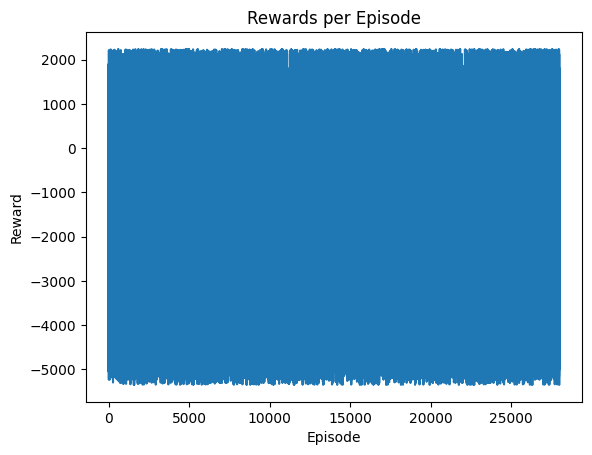

In [1582]:
import matplotlib.pyplot as plt

# Assuming you have a list of rewards for each episode
#rewards_per_episode = [...]  # Populate this with your actual data

plt.plot(rewards_per_episode)
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('Rewards per Episode')
plt.show()


In [1583]:
# Tuning

def train_q_learning(alpha, gamma, epsilon, min_epsilon, decay_rate, n_episodes, n_states, n_actions, rewards):
    q_table = np.zeros((n_states, n_actions))
    rewards_per_episode = []

    for episode in range(n_episodes):
        current_state = np.random.randint(0, n_states)
        total_reward = 0

        while current_state < n_states - 1:
            if np.random.uniform(0, 1) < epsilon:
                action = np.random.randint(0, n_actions)
            else:
                action = np.argmax(q_table[current_state])

            next_state = current_state + 1  # Adjust based on environment logic
            reward = rewards[next_state]

            best_next_action = np.argmax(q_table[next_state])
            q_table[current_state, action] += alpha * (
                reward + gamma * q_table[next_state, best_next_action] - q_table[current_state, action]
            )

            total_reward += reward
            current_state = next_state

        rewards_per_episode.append(total_reward)
        epsilon = max(min_epsilon, epsilon * decay_rate)

    return q_table, rewards_per_episode


In [1584]:

def evaluate_q_learning_reward_weighted(q_table, n_states, train_data, rewards):
    correct_predictions = 0
    total_reward = 0
    reward_weighted_accuracy = []

    for state_index in range(n_states):
        predicted_action = np.argmax(q_table[state_index])  # Predicted action
        actual_action = train_data["action_num"].iloc[state_index]  # Actual action
        reward = rewards[state_index]  # Reward for the action

        if predicted_action == actual_action:
            correct_predictions += 1
            total_reward += reward

        accuracy = correct_predictions / (state_index + 1)
        reward_weighted_accuracy.append(total_reward / (state_index + 1))

        # Optional: Log progress
        if state_index % 100 == 0:
            print(f"Processed state {state_index}/{n_states} - Accuracy: {accuracy * 100:.2f}%, Reward-weighted Accuracy: {reward_weighted_accuracy[-1]}")

    final_reward_weighted_accuracy = total_reward / n_states
    return final_reward_weighted_accuracy * 100



In [ ]:
def evaluate_q_learning_prediction_efficiency(q_table, n_states, train_data, rewards):
    # Initialize cumulative rewards
    cumulative_predicted_reward = 0
    cumulative_actual_reward = 0

    # Iterate through states to calculate rewards
    for state_index in range(n_states - 1):
        # Predicted action from Q-table
        predicted_action = np.argmax(q_table[state_index])  # Best action for the current state
        # Actual action from the ground truth
        actual_action = train_data["action_num"].iloc[state_index]

        # Get reward for predicted action only if it matches the actual action
        if predicted_action == actual_action:
            predicted_reward = rewards[state_index + 1]  # Reward for the correct prediction
            cumulative_predicted_reward += predicted_reward

        # Get actual reward for the ground truth action
        actual_reward = rewards[state_index + 1]
        cumulative_actual_reward += actual_reward
    return cumulative_predicted_reward

In [1585]:
'''
def random_search_reward_weighted(n_iter, param_grid, n_states, n_actions, rewards, train_data):
    best_params = None
    best_reward_weighted_accuracy = float('-inf')

    for _ in tqdm(range(n_iter), desc="Searching for params ..."):
        alpha = random.choice(param_grid['alpha'])
        gamma = random.choice(param_grid['gamma'])
        epsilon = random.choice(param_grid['epsilon'])
        min_epsilon = random.choice(param_grid['decay_rate'])
        decay_rate = random.choice(param_grid['decay_rate'])
        n_episodes = random.choice(param_grid['n_episodes'])

        q_table, _ = train_q_learning(alpha, gamma, epsilon, min_epsilon, decay_rate, n_episodes, n_states, n_actions, rewards)
        reward_weighted_accuracy = evaluate_q_learning_reward_weighted(q_table, n_states, train_data, rewards)

        if reward_weighted_accuracy > best_reward_weighted_accuracy:
            best_reward_weighted_accuracy = reward_weighted_accuracy
            best_params = (alpha, gamma, epsilon, min_epsilon, decay_rate, n_episodes)

        print(f"Iteration Reward-weighted Accuracy: {reward_weighted_accuracy:.2f}%, Best Reward-weighted Accuracy: {best_reward_weighted_accuracy:.2f}%")

    return best_params, best_reward_weighted_accuracy

# Define the parameter grid
param_grid = {
    'alpha': [0.01, 0.05, 0.1, 0.2, 0.25, 0.3, 0.5, 0.7, 0.9, 1],
    'gamma': [0.75, 0.85, 0.9, 0.95, 0.99],
    'epsilon': [1.0, 0.5, 0.1, 0.05, 0.01],
    'min_epsilon': [0.05, 0.01, 0.005, 0.001, 0.001],
    'decay_rate': [0.95, 0.96, 0.97, 0.99, 0.995, 0.997, 0.999],
    'n_episodes': [1500, 4000,6000, 8000, 9000, 10000, 11000, 12000, 14000, 18000, 21000, 24000, 28000]
}

# Perform Random Search
best_params, best_reward_weighted_accuracy = random_search_reward_weighted(50, param_grid, n_states, n_actions, rewards, train_data)
print(f"Best Hyperparameters: {best_params}")
print(f"Best Reward-weighted Accuracy: {best_reward_weighted_accuracy:.2f}%")
'''


'\ndef random_search_reward_weighted(n_iter, param_grid, n_states, n_actions, rewards, train_data):\n    best_params = None\n    best_reward_weighted_accuracy = float(\'-inf\')\n\n    for _ in tqdm(range(n_iter), desc="Searching for params ..."):\n        alpha = random.choice(param_grid[\'alpha\'])\n        gamma = random.choice(param_grid[\'gamma\'])\n        epsilon = random.choice(param_grid[\'epsilon\'])\n        min_epsilon = random.choice(param_grid[\'decay_rate\'])\n        decay_rate = random.choice(param_grid[\'decay_rate\'])\n        n_episodes = random.choice(param_grid[\'n_episodes\'])\n\n        q_table, _ = train_q_learning(alpha, gamma, epsilon, min_epsilon, decay_rate, n_episodes, n_states, n_actions, rewards)\n        reward_weighted_accuracy = evaluate_q_learning_reward_weighted(q_table, n_states, train_data, rewards)\n\n        if reward_weighted_accuracy > best_reward_weighted_accuracy:\n            best_reward_weighted_accuracy = reward_weighted_accuracy\n        

In [ ]:
'''
def random_search_reward_weighted(n_iter, param_grid, n_states, n_actions, rewards, train_data):
    best_params = None
    best_cumulative_pred_reward = float('-inf')

    for _ in tqdm(range(n_iter), desc="Searching for params ..."):
        alpha = random.choice(param_grid['alpha'])
        gamma = random.choice(param_grid['gamma'])
        epsilon = random.choice(param_grid['epsilon'])
        min_epsilon = random.choice(param_grid['decay_rate'])
        decay_rate = random.choice(param_grid['decay_rate'])
        n_episodes = random.choice(param_grid['n_episodes'])

        q_table, _ = train_q_learning(alpha, gamma, epsilon, min_epsilon, decay_rate, n_episodes, n_states, n_actions, rewards)
        cumulative_pred_reward = evaluate_q_learning_prediction_efficiency(q_table, n_states, train_data, rewards)

        if cumulative_pred_reward > best_cumulative_pred_reward:
            best_cumulative_pred_reward = cumulative_pred_reward
            best_params = (alpha, gamma, epsilon, min_epsilon, decay_rate, n_episodes)

        print(f"Iteration cumulative predicted reward: {cumulative_pred_reward:.2f}%, Best cumulative predicted reward: {best_cumulative_pred_reward:.2f}%")

    return best_params, best_cumulative_pred_reward

# Define the parameter grid
param_grid = {
    'alpha': [0.01, 0.05, 0.1, 0.2, 0.25, 0.3, 0.5, 0.7, 0.9, 1],
    'gamma': [0.75, 0.85, 0.9, 0.95, 0.99],
    'epsilon': [1.0, 0.5, 0.1, 0.05, 0.01, 0.005],
    'min_epsilon': [0.05, 0.01, 0.005, 0.001, 0.001],
    'decay_rate': [0.95, 0.99, 0.995, 0.997, 0.999],
    'n_episodes': [1500, 4000,6000, 8000, 9000, 10000, 11000, 12000]
}

# Perform Random Search
best_params, best_cumulative_pred_reward = random_search_reward_weighted(50, param_grid, n_states, n_actions, rewards, train_data)
print(f"Best Hyperparameters: {best_params}")
print(f"Best cumulative predicted reward: {best_cumulative_pred_reward:.2f}%")
'''